# Further simplified version of the COMMOTIONS model for the pedestrian crossing scenario

Assuming that the pedestrian has the same value function as in previous implementations, for a predicted state $\mathbf{x}_P'(\mathbf{a})$ from applying action $\mathbf{a}$:

$$
V_{\mathbf{a}} = V(\mathbf{x}_P'(\mathbf{a}), \mathbf{a}) = k_g v - k_{dv} v^2 - k_e \Delta v^2 - k_c / \tau
$$

where $v$ is the predicted longitudinal speed, $\Delta v$ is the change in speed effectuated by action $\mathbf{a}$, $\tau$ is predicted time to collision with the other agent (infinite if no collision course), and the rest above are model parameters.

We now consider the simplified situation where a pedestrian has initial state $\mathbf{x}_{P0} = (y_P = y_{P0}, v_P = 0)$, and is wanting to walk (along the y axis) to cross a road (running along the x axis) on which a vehicle of length $L_V$ is approaching with constant speed $v_{V0}$ and initial distance $x_{V0}$ to the front of the car, such that the car's state over time is $\mathbf{x}_V(t) = (x_V(t) = x_{V0} - v_{V0} t, v_V(t) = v_{V0})$. The effective collision distance as perceived by the pedestrian is $D_C$, i.e., the pedestrian does not want to be within the perceived effective collision zone $y_P \in [-D_C, D_C]$ when the car arrives at position $x_V = 0$. (This is a slight simplification of the collision detection in the general COMMOTIONS framework.)

![scenario illustration](ped_Xing_scenario.png)

Now assume that the pedestrian's only two decision options at any point in time is to either remain standing, $v_P = 0$, or to apply a speed increase $\Delta v$, achieved by constant acceleration over an action duration $\Delta T$. Note that this is in line with the general COMMOTIONS framework, but limiting the pedestrian's speed change options to $\{0, \Delta v\}$. Also in line with the COMMOTIONS framework, assume that the pedestrian judges the value of these two decision options by making a prediction $T_p$ into the future under both actions, and then applying the value function above. 

Now, for a given fixed parameterisation of $(y_{P0}, \Delta v, \Delta T, T_p)$, the predicted states under the two actions are easy to define. For the action of remaining waiting:

$$
\mathbf{x}_P'(\mathrm{wait}) = \mathbf{x}_{P0}
$$

And for the action of beginning to cross:

$$
\begin{align}
    \mathbf{x}'_P(\mathrm{cross})   & \equiv (y_{P}'(\mathrm{cross}), v_{P}'(\mathrm{cross}))\\
                                    & = (y_{P_0} + \Delta v \Delta T / 2 + \Delta v (T_p - \Delta T), \Delta v) \\
                                    & = (y_{P0} + \Delta v (T_p - \Delta T / 2), \Delta v)
\end{align}
$$

Note that this expression is valid as long as $T_p \geq \Delta T$.

It does not seem limiting to fix the parameters $(y_{P0}, \Delta v, \Delta T, T_p)$, for example as in the following code snippet, which also implements the predictions mentioned above.






In [1]:
# function to get the predicted pedestrian state if beginning to cross
def get_pred_crossing_state(initial_ped_pos, ped_walking_speed, ped_pred_time, ped_action_duration):
    pred_ped_pos = initial_ped_pos + ped_walking_speed * (ped_pred_time - ped_action_duration/2)
    return (pred_ped_pos, ped_walking_speed)

# setting some constants regarding the pedestrian
INITIAL_PED_POS = -2.5 # m; y_{P0}
WALKING_SPEED = 1.3 # m/s; \Delta v
PRED_TIME = 0.5 # s; T_p
ACTION_DURATION = 0.5 # s; \Delta T

# get the predicted pedestrian state if waiting
PRED_STATE_WAITING = (INITIAL_PED_POS, 0) # x_P'(wait)
print("Predicted pedestrian state (y position, speed) a time T_p = %.1f s into the future if waiting:" % PRED_TIME)
print(PRED_STATE_WAITING)

# get the predicting pedestrian state if beginning to cross
PRED_STATE_CROSSING = get_pred_crossing_state(INITIAL_PED_POS, WALKING_SPEED, PRED_TIME, ACTION_DURATION)
print("Predicted pedestrian state (y position, speed) a time T_p = %.1f s into the future if beginning to cross:" % PRED_TIME)
print(PRED_STATE_CROSSING)

Predicted pedestrian state (y position, speed) a time T_p = 0.5 s into the future if waiting:
(-2.5, 0)
Predicted pedestrian state (y position, speed) a time T_p = 0.5 s into the future if beginning to cross:
(-2.175, 1.3)


Now based on the above it is clear that the value of waiting will always be:

$$
V_{\mathrm{wait}} = 0
$$

and the value of beginning to cross will be:

$$
\begin{align}
    V_{\mathrm{cross}}(t)  & = k_g \Delta v - k_{dv} v^2 - k_e \Delta v^2  - k_c / \tau(t)\\
                        & = k_g \Delta v - (k_{dv} + k_e) \Delta v^2  - k_c / \tau(t)
\end{align}
$$

where 

$$
\tau(t) = \left\{
    \begin{array}{lll}
        \infty & \mbox{if} & TTA'(t) \geq T_C \\
        TTA'(t) & \mbox{if} & 0 \leq TTA'(t) < T_C \\
        0 & \mbox{if} & -T_L \leq TTA'(t) < 0 \\
        \infty & \mbox{if} & TTA'(t) < -T_L
    \end{array} 
    \right.
$$

where in turn $TTA'(t)$ is the predicted time to arrival of the car:

$$
TTA'(t) = \frac{x_{V0} - v_{V0} \cdot (t + T_p)}{v_{V0}} 
$$

and $T_C$ is the predicted time left for the pedestrian to reach the other side of the perceived effective collision zone $y_P \in [-D_C, D_C]$:

$$
T_C = \frac{D_C - y_{P}'(\mathrm{cross})}{v_{P}'(\mathrm{cross})}
$$

and $T_L = L_V / v_{V0}$ is the time needed for the length $L_V$ of the car to pass the pedestrian.

In [2]:

# function for getting the time left until reaching the other side of the collision zone from a predicted pedestrian state
def get_pred_crossing_time_to_safety(pred_ped_state_crossing, ped_collision_dist):
    pred_pos = pred_ped_state_crossing[0]
    pred_speed = pred_ped_state_crossing[1]
    pred_time_to_safety = (ped_collision_dist - pred_pos) / pred_speed # T_C
    return pred_time_to_safety

# parameter defining the radius of the collision zone
COLLISION_DIST = 2 # m; D_C

# get the predicted remaining time to cross the road, given the parameter values set above in this notebook
PRED_TIME_TO_SAFETY = get_pred_crossing_time_to_safety(PRED_STATE_CROSSING, COLLISION_DIST)
print("If beginning to cross, the predicted time until exiting the collision zone is %.2f s after the prediction interval T_p." % PRED_TIME_TO_SAFETY)

If beginning to cross, the predicted time until exiting the collision zone is 3.21 s after the prediction interval T_p.


So now, for a given scenario defined by the initial car state $\mathbf{x}_{V0} = (x_{V0}, v_{V0})$ and for a given set of gains $k_{*}$ for the value function, we can calculate $V_{\mathrm{cross}}(t)$ for arbitrary $t$. The function below does that, calling the other function we defined above.

In [3]:
import math
import numpy as np

def get_pred_veh_ttas(initial_veh_pos, veh_speed, ped_pred_time, time_values):
    pred_veh_TTAs = (initial_veh_pos - veh_speed * (time_values + ped_pred_time)) / veh_speed
    return pred_veh_TTAs

def get_values_of_crossing(initial_ped_pos, ped_walking_speed, ped_pred_time, ped_action_duration, \
    ped_collision_dist, ped_value_fcn_k, initial_veh_pos, veh_speed, veh_length, time_values):
    # get the (time-independent) predicted pedestrian state x_p'(cross) if beginning to cross
    pred_ped_state_crossing = get_pred_crossing_state(initial_ped_pos, ped_walking_speed, ped_pred_time, ped_action_duration)
    # get the (time-independent) predicted time left to crossing safely if beginning to cross
    pred_time_to_safety = get_pred_crossing_time_to_safety(pred_ped_state_crossing, ped_collision_dist)
    # get predicted vehicle TTAs, and corresponding taus, as a function of time in the scenario
    pred_veh_TTAs = get_pred_veh_ttas(initial_veh_pos, veh_speed, ped_pred_time, time_values)
    veh_passing_time = veh_length / veh_speed
    taus = pred_veh_TTAs
    taus[np.nonzero(pred_veh_TTAs > pred_time_to_safety)] = math.inf
    taus[np.nonzero(np.logical_and(pred_veh_TTAs < 0, pred_veh_TTAs >= -veh_passing_time))] = 0
    taus[np.nonzero(pred_veh_TTAs < -veh_passing_time)] = math.inf
    # calculate the value of beginning to cross, as a function of time in the scenario
    # - time-independent terms
    const_value_of_walking = ped_value_fcn_k._g * ped_walking_speed \
        - (ped_value_fcn_k._dv + ped_value_fcn_k._e) * ped_walking_speed ** 2
    # - time-dependent (collision course related) term
    collision_course_values = - ped_value_fcn_k._c / taus
    # - get the total value
    values = const_value_of_walking + collision_course_values
    return values


Below an example scenario, where we have fixed $k_{dv}$ to get the $\Delta v$ as the free flow speed arising from the value function, and $k_e = 0$, i.e., neglecting speed change effort, essentially leaving $k_c$ as the only free model parameter so far.

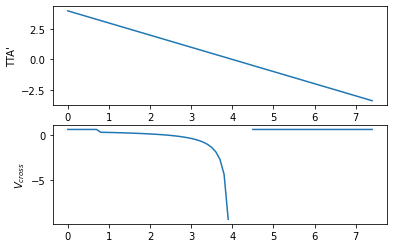

In [4]:
import commotions
import matplotlib.pyplot as plt

# scenario definition
INITIAL_VEH_POS = 45 # m
VEH_SPEED = 10 # m/s
VEH_LENGTH = 4.5 # m
TIME_STEP = 0.1 # s
END_TIME = INITIAL_VEH_POS / VEH_SPEED + 3
TIME_STAMPS = np.arange(0, END_TIME, TIME_STEP)
N_TIME_STEPS = len(TIME_STAMPS)

# value function gains
VALUE_FCN_k = commotions.Parameters()
VALUE_FCN_k._g = 1 
VALUE_FCN_k._dv = VALUE_FCN_k._g / (2 * WALKING_SPEED) # makes WALKING_SPEED the free flow speed for the pedestrian
VALUE_FCN_k._e = 0 
VALUE_FCN_k._c = 1 # free parameter

# get the values for this scenario
crossing_values = get_values_of_crossing(initial_ped_pos=INITIAL_PED_POS, ped_walking_speed=WALKING_SPEED, \
    ped_pred_time=PRED_TIME, ped_action_duration=ACTION_DURATION, ped_collision_dist=COLLISION_DIST, \
    ped_value_fcn_k=VALUE_FCN_k, initial_veh_pos=INITIAL_VEH_POS, veh_speed=VEH_SPEED, veh_length = VEH_LENGTH, \
    time_values=TIME_STAMPS)

# plot
plt.subplot(2, 1, 1)
plt.plot(TIME_STAMPS, get_pred_veh_ttas(INITIAL_VEH_POS, VEH_SPEED, PRED_TIME, TIME_STAMPS))
plt.ylabel("TTA'")
plt.subplot(2, 1, 2)
plt.plot(TIME_STAMPS, crossing_values)
plt.ylabel("$V_{cross}$")
plt.show()

To get a rate of evidence accumulation (drift rate) from this value estimate, we take the low-pass filter approach described in the model scoping document (Eq. (8) in the 2020-11-25 version):

$$
T \frac{d \Delta \hat{V}_{\mathrm{cross}}(t)}{dt} = \Delta V_{\mathrm{cross}}(t) - \Delta \hat{V}_{\mathrm{cross}}(t)
$$

Here, $\Delta \hat{V}_{\mathrm{cross}}(t)$ is the accumulated evidence, but let's simplify notation a bit by defining $\xi(t) \equiv \Delta \hat{V}_{\mathrm{cross}}(t)$, and also use that

$$
\begin{align}
    \Delta V_{\mathrm{cross}}(t) & \equiv V_{\mathrm{cross}}(t) - V_{\mathrm{wait}}(t) \\
                                & = \{ V_{\mathrm{wait}}(t) = 0 \} \\
                                & = V_{\mathrm{cross}}(t)
\end{align}
$$

such that we get:

$$
T \frac{d \xi}{dt} = V_{\mathrm{cross}}(t) - \xi(t)
$$
$$
\frac{d \xi}{dt} = \frac{1}{T} \left( V_{\mathrm{cross}}(t) - \xi(t) \right)
$$
$$
d \xi = \frac{1}{T} \left( V_{\mathrm{cross}}(t) - \xi(t) \right) dt
$$

Generalising in a similar way as in Eq. (12) in the scoping doc (v 2020-11-25):

$$
d \xi = \left( \beta V_{\mathrm{cross}}(t) - \gamma \xi(t) \right) dt
$$

where setting $\beta = \gamma = 1/T$ yields the low-pass filter version above, whereas with $\beta = 1, \gamma = 0$ we get a simpler, direct value accumulation scheme:

$$
d \xi = V_{\mathrm{cross}}(t) dt
$$


## Some different evidence accumulation formulations

We can now run trials with evidence accumulation, using any of a number of different formulations, which are now formulated similarly to the Zgonnikov et al (2020) model, using the $d \xi = ...$ drift rate formulation, such that it should presumably be possible to use any of these with PyDDM or similar.

### Direct value accumulation 

Rirst testing the direct value accumulation formulation ($\beta = 1, \gamma = 0$), for which the drift rate $d \xi = V_{\mathrm{cross}}(t) dt$, and introducing a decision threshold $\xi_{th}$ for deciding to cross:

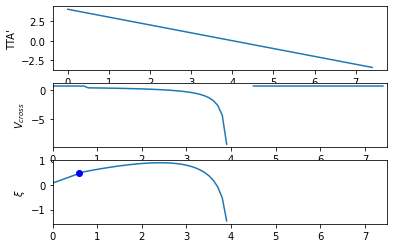

In [5]:
DECISION_THRESHOLD = 0.4 # free parameter xi_th

drift_rates = crossing_values
evidence_deltas = drift_rates * TIME_STEP
evidence = np.cumsum(evidence_deltas)

def get_crossing_onset(time_stamps, evidence, decision_threshold):
    above_thresh_samples = np.argwhere(evidence >= decision_threshold)
    if len(above_thresh_samples) > 0:
        crossing_sample = above_thresh_samples[0]
        crossing_time = time_stamps[crossing_sample]
    else:
        crossing_sample = math.nan
        crossing_time = math.nan
    return (crossing_sample, crossing_time)

crossing_sample, crossing_time = get_crossing_onset(TIME_STAMPS, evidence, DECISION_THRESHOLD)

# plot
plt.subplot(3, 1, 1)
plt.plot(TIME_STAMPS, get_pred_veh_ttas(INITIAL_VEH_POS, VEH_SPEED, PRED_TIME, TIME_STAMPS))
plt.ylabel("TTA'")
plt.subplot(3, 1, 2)
plt.xlim((0, END_TIME))
plt.plot(TIME_STAMPS, crossing_values)
plt.ylabel("$V_{cross}$")
plt.xlim((0, END_TIME))
plt.subplot(3, 1, 3)
plt.plot(TIME_STAMPS, evidence)
if not math.isnan(crossing_time):
    plt.plot(TIME_STAMPS[crossing_sample], evidence[crossing_sample], 'bo')
plt.ylabel("$\\xi$")
plt.xlim((0, END_TIME))
plt.show()


This type of scheme could be sufficient if we just want to model frequency of crossing before the car, and the timing of these crossings, but the discontinuity in $V_{\mathrm{cross}}(t)$ means that we can't explicitly model the crossings happening after the car has passed (i.e., in the cases when the decision threshold isn't reached before the car arrives at the pedestria). However, if we want to compare only to the Zgonnikov et al (2020) model (especially the one without collapsing bounds), this type of model could be the way to go. 

### Direct accumulation of squashed value

One way to deal with the discontinuity in $V_{\mathrm{cross}}(t)$ is to include the squashing sigmoidal function $f$ introduced in Eq. (13) of the model scoping doc (same version as before), such that we can rewrite the drift rates:

$$
d \xi = \frac{1}{T} \left( f[V_{\mathrm{cross}}(t)] - \xi(t) \right) dt
$$

or in the generalised form:

$$
d \xi = \left( \beta \cdot f[V_{\mathrm{cross}}(t)] - \gamma \xi(t) \right) dt
$$

Which in the direct value accumulation scheme ($\beta = 1, \gamma = 0$) becomes:

$$
d \xi = f[V_{\mathrm{cross}}(t)] dt
$$

As sigmoid we could for example use:

$$
f(V) = \tanh \frac{V}{V_0}
$$

with $V_0$ a free parameter determining the scale of the activation function.


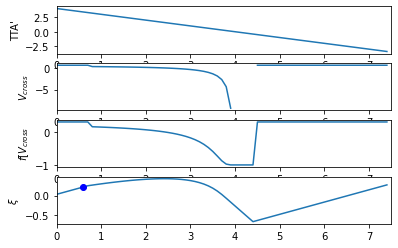

In [6]:
def tanh_sigmoid(x, V0):
    return np.tanh(x / V0)

VALUE_SIGMOID_SCALE = 2 # free parameter V_0
DECISION_THRESHOLD = 0.2 # free parameter xi_th (now in units of squashed value)

squashed_crossing_values = tanh_sigmoid(crossing_values, VALUE_SIGMOID_SCALE)

drift_rates = squashed_crossing_values
evidence_deltas = drift_rates * TIME_STEP
evidence = np.cumsum(evidence_deltas)
crossing_sample, crossing_time = get_crossing_onset(TIME_STAMPS, evidence, DECISION_THRESHOLD)

# plot
plt.subplot(4, 1, 1)
plt.plot(TIME_STAMPS, get_pred_veh_ttas(INITIAL_VEH_POS, VEH_SPEED, PRED_TIME, TIME_STAMPS))
plt.ylabel("TTA'")
plt.xlim((0, END_TIME))
plt.subplot(4, 1, 2)
plt.plot(TIME_STAMPS, crossing_values)
plt.ylabel("$V_{cross}$")
plt.xlim((0, END_TIME))
plt.subplot(4, 1, 3)
plt.plot(TIME_STAMPS, squashed_crossing_values)
plt.ylabel("$f[V_{cross}}]$")
plt.xlim((0, END_TIME))
plt.subplot(4, 1, 4)
plt.plot(TIME_STAMPS, evidence)
if not math.isnan(crossing_time):
    plt.plot(TIME_STAMPS[crossing_sample], evidence[crossing_sample], 'bo')
plt.ylabel("$\\xi$")
plt.xlim((0, END_TIME))
plt.show()

The evidence accumulation can now continue also after the car has passed, but we see that the lack of "forgetting" in the evidence accumulation becomes problematic: While the car is passing, a large negative $\xi$ accumulates, such that it takes a long time to climb back toward the positive decision threshold for crossing.

### Low-pass filter accumulation of squashed value

To include "forgetting", we can return to the low-pass filter formulation of the evidence accumulation $(\beta = \gamma = 1/T)$, i.e.,

$$
d \xi = \frac{1}{T} \left( f[V_{\mathrm{cross}}(t)] - \xi(t) \right) dt
$$

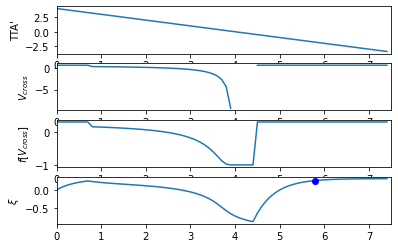

In [7]:

ACCUM_TIME_SCALE = 0.5 # s; free parameter T
DECISION_THRESHOLD = 0.25 # xi_th - new value again, since value estimate is now low-pass filtered

# now need to run the trial as a for loop, since there is feedback
def get_lpfilt_squashed_value_evidence(n_time_steps, time_step, values, value_sigmoid_scale, accum_time_scale):
    evidence = np.full(n_time_steps, math.nan)
    evidence[0] = 0
    squashed_values = tanh_sigmoid(values, value_sigmoid_scale)
    for i_time_step in range(1, n_time_steps):
        evidence_rate = (squashed_values[i_time_step] - evidence[i_time_step-1]) / accum_time_scale
        evidence[i_time_step] = evidence[i_time_step-1] + evidence_rate * time_step
    return evidence

evidence = get_lpfilt_squashed_value_evidence(N_TIME_STEPS, TIME_STEP, crossing_values, \
    VALUE_SIGMOID_SCALE, ACCUM_TIME_SCALE)
crossing_sample, crossing_time = get_crossing_onset(TIME_STAMPS, evidence, DECISION_THRESHOLD)

# plot
plt.subplot(4, 1, 1)
plt.plot(TIME_STAMPS, get_pred_veh_ttas(INITIAL_VEH_POS, VEH_SPEED, PRED_TIME, TIME_STAMPS))
plt.ylabel("TTA'")
plt.xlim((0, END_TIME))
plt.subplot(4, 1, 2)
plt.plot(TIME_STAMPS, crossing_values)
plt.ylabel("$V_{cross}$")
plt.xlim((0, END_TIME))
plt.subplot(4, 1, 3)
plt.plot(TIME_STAMPS, squashed_crossing_values)
plt.ylabel("$f[V_{cross}]$")
plt.xlim((0, END_TIME))
plt.subplot(4, 1, 4)
plt.plot(TIME_STAMPS, evidence)
if not math.isnan(crossing_time):
    plt.plot(TIME_STAMPS[crossing_sample], evidence[crossing_sample], 'bo')
plt.ylabel("$\\xi$")
plt.xlim((0, END_TIME))
plt.show()

I think this could be a type of model which might work rather well for modelling crossing both before and after the car has passed. For clarity, below I am running again what was run just above, but collecting the code run in steps throughout this notebook into a single code block, and highlighting what I have here considered free parameters:

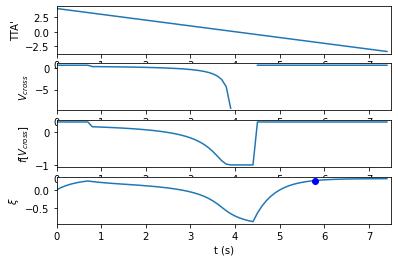

In [57]:
# free parameters
VALUE_FCN_k._c = 1 # k_c
VALUE_SIGMOID_SCALE = 2 # V_0
DECISION_THRESHOLD = 0.25 # xi_th
ACCUM_TIME_SCALE = 0.5 # s; T

# get values for crossing as a function of time
crossing_values = get_values_of_crossing(initial_ped_pos=INITIAL_PED_POS, ped_walking_speed=WALKING_SPEED, \
    ped_pred_time=PRED_TIME, ped_action_duration=ACTION_DURATION, ped_collision_dist=COLLISION_DIST, \
    ped_value_fcn_k=VALUE_FCN_k, initial_veh_pos=INITIAL_VEH_POS, veh_speed=VEH_SPEED, veh_length = VEH_LENGTH, \
    time_values=TIME_STAMPS)

# simulate the trial with low-pass filtered squashed value accumulation
evidence = get_lpfilt_squashed_value_evidence(N_TIME_STEPS, TIME_STEP, crossing_values, \
    VALUE_SIGMOID_SCALE, ACCUM_TIME_SCALE)
crossing_sample, crossing_time = get_crossing_onset(TIME_STAMPS, evidence, DECISION_THRESHOLD)

# plot
plt.subplot(4, 1, 1)
plt.plot(TIME_STAMPS, get_pred_veh_ttas(INITIAL_VEH_POS, VEH_SPEED, PRED_TIME, TIME_STAMPS))
plt.ylabel("TTA'")
plt.xlim((0, END_TIME))
plt.subplot(4, 1, 2)
plt.plot(TIME_STAMPS, crossing_values)
plt.ylabel("$V_{cross}$")
plt.xlim((0, END_TIME))
plt.subplot(4, 1, 3)
plt.plot(TIME_STAMPS, squashed_crossing_values)
plt.ylabel("$f[V_{cross}]$")
plt.xlim((0, END_TIME))
plt.subplot(4, 1, 4)
plt.plot(TIME_STAMPS, evidence)
if not math.isnan(crossing_time):
    plt.plot(TIME_STAMPS[crossing_sample], evidence[crossing_sample], 'bo')
plt.xlabel("t (s)")
plt.ylabel("$\\xi$")
plt.xlim((0, END_TIME))
plt.show()

### Low-pass filter accumulation of squashed noisy value

We can now introduce noise in the evidence accumulation. I think it makes most sense to do so by making the value estimate noisy (i.e., before squashing).  

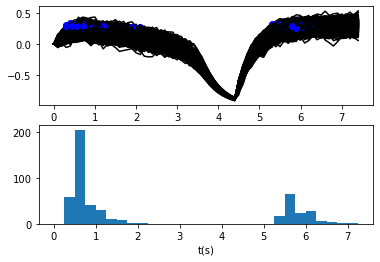

In [58]:

VALUE_NOISE_STDDEV = 1.5

N_TRIALS = 500
crossing_times = np.full(N_TRIALS, math.nan)
plt.subplot(2, 1, 1)
for i_trial in range(N_TRIALS):
    # get noise
    trial_value_noises = VALUE_NOISE_STDDEV * np.random.randn(N_TIME_STEPS) * math.sqrt(TIME_STEP)
    # add noise to values for crossing
    trial_noisy_values = crossing_values + trial_value_noises
    # simulate the trial, with noisy crossing values
    trial_evidence = get_lpfilt_squashed_value_evidence(N_TIME_STEPS, TIME_STEP, trial_noisy_values, \
        VALUE_SIGMOID_SCALE, ACCUM_TIME_SCALE)
    noisy_cross_sample, noisy_cross_time = get_crossing_onset(TIME_STAMPS, trial_evidence, DECISION_THRESHOLD)
    # plot trial
    plt.plot(TIME_STAMPS, trial_evidence, 'k') 
    if not math.isnan(noisy_cross_time):
        plt.plot(TIME_STAMPS[noisy_cross_sample], trial_evidence[noisy_cross_sample], 'bo')
    # save the crossing time obtained for this trial
    crossing_times[i_trial] = noisy_cross_time

# plot histogram of crossing times
plt.subplot(2, 1, 2)
plt.hist(crossing_times, np.arange(0, END_TIME, 0.25))
plt.xlabel("t(s)")
plt.show()


# Implementation of the Pekkanen et al VDDM

An implementation of the pedestrian crossing VDDM developed in interACT by Pekkanen et al (in prep.), as a further development of the "S-VDDM" of [Giles et al. (2019)](https://cogsci.mindmodeling.org/2019/papers/0083/index.html).

Following the notation in the (draft) Pekkanen et al. paper and denoting time to arrival by $\tau$, and writing the generalised time to arrival:

$$
\begin{align}
    \bar{\tau} = & \tau(t) \\
                & + \beta_D (D(t) / v' - \tau(t)) \\
                & + \beta_{\dot{\tau}} (\dot{\tau}(t) + 1) \\
                & + \infty \mbox{ if } \tau(t) < \tau_p \mbox{, 0 otherwise}
\end{align}
$$

I am skipping the $H(t)$ term since at the moment we are not considering explicit communication like eHMI messages. Also the $\dot{\tau}$ term above is somewhat superfluous since we are only considering constant-speed scenarios at the moment, but I am implementing it anyway for future reference.

Throughout below I will be using the maximum likelihood estimates of the model parameter shown in Fig. 3 of the (draft) Pekkanen et al. paper, and the same pedestrian crossing scenario as considered above for the COMMOTIONS model.

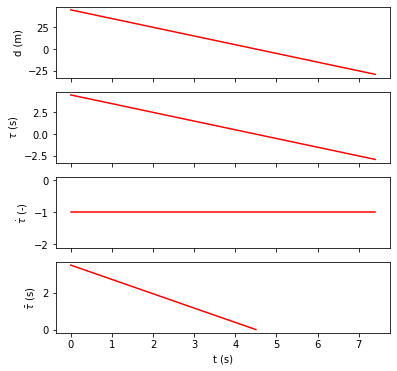

In [66]:
# constant v' fixed at 50 km/h
VPRIME = 50 / 3.6 

# parameter values from Fig 3
BETA_D = 0.8
BETA_TAUDOT = 0.6
TAU_P = -0.1

# basics
veh_dists = INITIAL_VEH_POS - VEH_SPEED * TIME_STAMPS
taus = veh_dists / VEH_SPEED
taubars = np.copy(taus)

# distance term
taubars += BETA_D * (veh_dists / VPRIME - taus)

# acceleration term
# - simple numerical differentation (will be all -1 in constant-speed scenarios)
taudots = np.diff(taus) / TIME_STEP
# - duplicate the first element of taudots to make it the same number of samples as the other arrays (could also just insert zero)
taudots = np.insert(taudots, 0, taudots[0])
# - add term
taubars += BETA_TAUDOT * (taudots + 1)

# vehicle passed term
# - find the elements
veh_passed_idxs = np.nonzero(taus < TAU_P)[0]
# - set to infinity
taubars[veh_passed_idxs] = math.inf

# plot
fig = plt.figure(figsize = (6,6))
axs = fig.subplots(4, 1, sharex = True)
axs[0].plot(TIME_STAMPS, veh_dists, 'r-')
axs[0].set_ylabel('d (m)')
axs[1].plot(TIME_STAMPS, taus, 'r-')
axs[1].set_ylabel('$\\tau$ (s)')
axs[2].plot(TIME_STAMPS, taudots, 'r-')
axs[2].set_ylabel('$\dot{\\tau}$ (-)')
axs[2].set_ylim((-2.1, 0.1))
axs[3].plot(TIME_STAMPS, taubars, 'r-')
axs[3].set_ylabel('$\\bar{\\tau}$ (s)')
axs[3].set_xlabel('t (s)')
plt.show()


In the plot above, $\bar{\tau}$ disappears at about 4.5 s because it goes to infinity when the vehicle has just passed ($\tau < \tau_p$).

The next step is to apply a squashing function:

$$
s(t) = \arctan(m(\bar{\tau}(t) - \bar{\tau}'))
$$


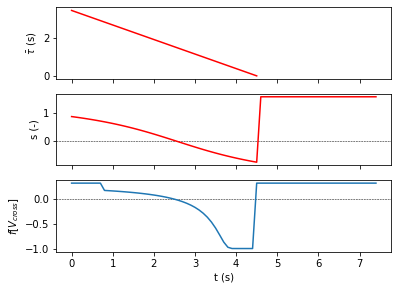

In [67]:
# parameter values from Fig 3
M = 0.6
TAUBARPRIME = 1.5

ss = np.arctan(M * (taubars - TAUBARPRIME))

# plot
fig = plt.figure(figsize = (6,4.5))
axs = fig.subplots(3, 1, sharex = True)
axs[0].plot(TIME_STAMPS, taubars, 'r-')
axs[0].set_ylabel('$\\bar{\\tau}$ (s)')
axs[1].axhline(0, linestyle='--', color='k', lw=0.5)
axs[1].plot(TIME_STAMPS, ss, 'r-')
axs[1].set_ylabel('s (-)')
axs[2].axhline(0, linestyle='--', color='k', lw=0.5)
axs[2].plot(TIME_STAMPS, squashed_crossing_values)
axs[2].set_ylabel("$f[V_{cross}]$")
axs[2].set_xlabel('t (s)')
plt.show()

Above I also replotted $f[V_{\mathrm{cross}}]$ from the COMMOTIONS model, just to illustrate how the drift rates of the two models are similar in that they are positive/negative during approximately the same periods of time in the scenario, but the COMMOTIONS model inhibits crossing much more drastically at smaller times to arrival.

We can now implement the Pekkanen et al evidence accumulation, written in discrete update form as:

$$
\Delta A[i] = (-\alpha A[i-1] + s[i]) \Delta t + \epsilon[i]
$$

Showing it first below without any noise

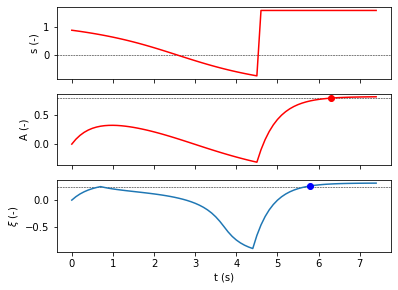

In [72]:
def get_pekkanen_evidence(n_time_steps, time_step, ss, alpha, sigma):
    As = np.full(n_time_steps, math.nan)
    As[0] = 0
    for i_time_step in range(1, n_time_steps):
        delta_A = ((-alpha * As[i_time_step - 1] + ss[i_time_step]) * time_step 
                   + np.random.randn() * sigma * math.sqrt(time_step))
        As[i_time_step] = As[i_time_step-1] + delta_A
    return As

# parameters from Fig 3
ALPHA = 1.9
APRIME = 0.8

# get non-noisy evidence and crossing time
As = get_pekkanen_evidence(N_TIME_STEPS, TIME_STEP, ss, ALPHA, sigma=0)
pekk_cross_sample, pekk_cross_time = get_crossing_onset(TIME_STAMPS, As, APRIME)

# plot
fig = plt.figure(figsize = (6,4.5))
axs = fig.subplots(3, 1, sharex = True)
axs[0].axhline(0, linestyle='--', color='k', lw=0.5)
axs[0].plot(TIME_STAMPS, ss, 'r-')
axs[0].set_ylabel('s (-)')
axs[1].axhline(APRIME, linestyle='--', color='k', lw=0.5)
axs[1].plot(TIME_STAMPS, As, 'r-')
axs[1].set_ylabel('A (-)')
if not math.isnan(pekk_cross_time):
    axs[1].plot(TIME_STAMPS[pekk_cross_sample], As[pekk_cross_sample], 'ro')
axs[2].axhline(DECISION_THRESHOLD, linestyle='--', color='k', lw=0.5)
axs[2].plot(TIME_STAMPS, evidence)
if not math.isnan(crossing_time):
    axs[2].plot(TIME_STAMPS[crossing_sample], evidence[crossing_sample], 'bo')
axs[2].set_ylabel("$\\xi$ (-)")
axs[2].set_xlabel('t (s)')
plt.show()


Again I am plotting also the $\xi$ of the COMMOTIONS model above for comparison (in the plot it looks as if the COMMOTIONS model surpasses its decision threshold at about 0.7 s, but the peak is actually just below the threshold).

Now running a number of simulations of the Pekkanen et al. model, with noise included.

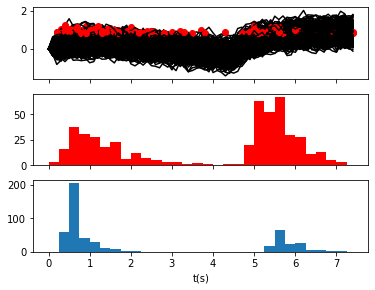

In [69]:
# parameter from Fig 3
SIGMA = 0.6

pekk_crossing_times = np.full(N_TRIALS, math.nan)
fig = plt.figure(figsize = (6,4.5))
axs = fig.subplots(3, 1, sharex = True)
for i_trial in range(N_TRIALS):
    # simulate the trial, with noise
    noisy_As = get_pekkanen_evidence(N_TIME_STEPS, TIME_STEP, ss, ALPHA, SIGMA)
    noisy_pekk_cross_sample, noisy_pekk_cross_time = get_crossing_onset(TIME_STAMPS, noisy_As, APRIME)
    # plot trial
    axs[0].plot(TIME_STAMPS, noisy_As, 'k') 
    if not math.isnan(noisy_pekk_cross_time):
        axs[0].plot(TIME_STAMPS[noisy_pekk_cross_sample], noisy_As[noisy_pekk_cross_sample], 'ro')
    # save the crossing time obtained for this trial
    pekk_crossing_times[i_trial] = noisy_pekk_cross_time

# plot histogram of crossing times
hist_edges = np.arange(0, END_TIME, 0.25)
axs[1].hist(pekk_crossing_times, hist_edges, facecolor='r')
axs[2].hist(crossing_times, hist_edges)
plt.xlabel("t(s)")
plt.show()

And again plotting the corresponding distribution for the COMMOTIONS model (bottom panel) for comparison. Note above that the Pekkanen et al. model has a non-negligible tail of crossings in the 2.5-4.5 s time range, i.e., during times when the vehicle's time to arrival is rather close. This was perhaps the biggest problem for the model as described in the (draft) Pekkanen et al. paper. However, due to the strong inhibition of crossing at low TTAs, the COMMOTIONS model does not cross at all in the 2.5-4.5 s time region. 

# Exploring modifications towards v0.2 of the framework

To extend the framework to also consider the impact of potential time losses on the value of actions and resulting behaviour, we can generalise the value formulation further, from: 
$$
V_{\mathbf{a}} = V[\mathbf{x}'(\mathbf{a}), \mathbf{a}] 
$$
as above (but now using $\mathbf{x}$ to denote state for a general agent, rather than $\mathbf{x}_P$ for the pedestrian), to:
$$
V_{\mathbf{a}} = \max_{\Omega} V[\mathbf{x}'(\mathbf{a}), \mathbf{a}, \Omega] 
$$
where $\Omega$ is now the *interaction outcome*, in terms of who passes the conflict space first, $\Omega_1$ and $\Omega_2$ denoting the agent itself passing first and second, respectively. In other words, we are now suggesting that the value of a predicted state may (sometimes) depend on what the ultimate interaction outcome is. Let's divide this outcome-dependent value estimate into two parts:
$$
V[\mathbf{x}'(\mathbf{a}), \mathbf{a}, \Omega] = V_P[\mathbf{x}, \mathbf{a}] + V_R[\mathbf{x}'(\mathbf{a}), \Omega]
$$
where $V_P$ denotes the values realised during the prediction interval itself, and $V_R$ denotes the (time-discounted) remaining value that is expected beyond the prediction interval. Note that $V_P$ is independent of the interaction outcome $\Omega$ and that $V_R$ depends on the action $\mathbf{a}$ only indirectly via the impact of $\mathbf{a}$ on the predicted state $\mathbf{x}_P'(\mathbf{a})$. 

We can now reformulate the basic value of making progress and discomforts from speed and accelerations:
$$
V_P[\mathbf{x}'(\mathbf{a}), \mathbf{a}] = T_P \cdot f_V(\bar{v}, \bar{a}) \equiv T_P \cdot (k_g \bar{v} - k_{dv} \bar{v}^2 - k_{da} \bar{a}^2)
$$
where $\bar{v}$ and $\bar{a}$ are the average speed and acceleration during the prediction interval $T_P$, under action $\mathbf{a}$. Note that we have now changed things slightly compared to the v0.1 framework, to instead express these values as rates per time unit, as signalled by the multiplication with $T_P$. (I have now here also opted for writing the speed change discomfort as dependent on acceleration directly, with gain $k_{da}$, rather than as dependent on the change in speed, with parameter $k_e$, as in the v0.1 equations above - it is essentially the same thing though.)

The remaining value might possibly be written as:
$$
V_R[\mathbf{x}'(\mathbf{a}), \Omega] = T_{\Omega} \cdot f_V(\bar{v}_{\Omega}, \bar{a}_{\Omega}) - k_w T_{\Omega,w} \cdot f_V(v^*, 0)
$$
where the function $f_V$ is the same as defined just above. The first term on the right hand side represents the value of what will be needed after the prediction interval $T_P$ to achieve outcome $\Omega$, i.e., it is predicting a duration of time $T_{\Omega}$ during which average speed and acceleration will be $\bar{v}_{\Omega}$ and $\bar{a}_{\Omega}$, to achieve either passing ahead of the other agent ($\Omega = \Omega_1$) or after it ($\Omega = \Omega_2$). The second term accounts for any waiting time $T_{\Omega,w}$ that will also need to be respected under outcome $\Omega$, before the agent can return to progressing at its free speed $v^*$. (These expressions are derived from an approximation of a general formulation of value that can be thought of as a "delay-discounted pac-man" sort of scenario, i.e., where the agent gets value per distance travelled, but where values further into the future are discounted, for example exponentially. Not writing that full derivation down here now though.)



## Application to the pedestrian crossing scenario

Under this new value formulation, we still have the same predicted pedestrian states under the two possible actions:

$$
\mathbf{x}_P'(\mathrm{wait}) = \mathbf{x}_{P0}
$$
$$
    \mathbf{x}'_P(\mathrm{cross}) = (y_{P0} + \Delta v (T_p - \Delta T / 2), \Delta v)
$$

However the values of waiting and crossing have both changed:

$$
V[\mathbf{x}'(\mathbf{a}), \mathbf{a}, \Omega] = V_P[\mathbf{x}_{P0}, \mathbf{a}] + V_R[\mathbf{x}'(\mathbf{a}), \Omega] \\
$$

with

$$
V_P[\mathbf{x}_{P0}, \mathbf{a}] = 
    \left\{ 
        \begin{array}[ll]
            ? 0 & \mbox{if } \mathbf{a} = \mathrm{wait} \\
            T_P \cdot f_V(\frac{\Delta v}{2}, \frac{\Delta v}{\Delta T}) & \mbox{if } \mathbf{a} = \mathrm{cross} 
        \end{array}
    \right.
$$

and

$$
V_R[\mathbf{x}'(\mathbf{a}), \Omega] = T_{\Omega}[\mathbf{x}'(\mathbf{a})] \cdot f_V\{\bar{v}_{\Omega}[\mathbf{x}'(\mathbf{a})], \bar{a}_{\Omega}[\mathbf{x}'(\mathbf{a})]\} - k_w T_{\Omega,w}[\mathbf{x}'(\mathbf{a})] \cdot f_V(v^*, 0)
$$

where $T_{\Omega}(\mathbf{x}')$, $\bar{v}_{\Omega}(\mathbf{x}')$, and $\bar{a}_{\Omega}(\mathbf{x}')$ are now functions providing the duration, average speed, and average acceleration needed to achieve outcome $\Omega$ from a predicted state $\mathbf{x}'$, and $T_{\Omega,w}(\mathbf{x}')$ is the added waiting time associated with outcome $\Omega$ given the predicted state $\mathbf{x}'$.